# **Notebook for Text Removal from Medical Images**

## Motivation
The text present in a lot of medical images can disturb a lot of machine learning models. This notebook presents a method to detect the text and remove it using keras-ocr and opencv.

## Method

The text removal is done in 3 steps:
1. Compute the gradient of the image (grayscale) using sobel filters. This is done in compute_grad function. You can set mode to "double" if you want to compute the gradients on the magnitude of the first gradients. It helps to better filter the information of the image and keep the text.

2. The second step consists of detecting the text using keras ocr framework. A pretrained model is enough for this task 😄. The ocr algorithm will return multiple bounding boxes, so the function will compute their union and adds an offset.

3. Finally, the big bounding box will be used to filter the text from the image using opencv.


## Remark

Use the GPU if you have tons of images. From my experiments it took 750ms/image on GPU and 20sec! on CPU.

---
If you found this notebook helpful 🎉, an upvote will be a good motivation to keep sharing content with the community 🙌🙌

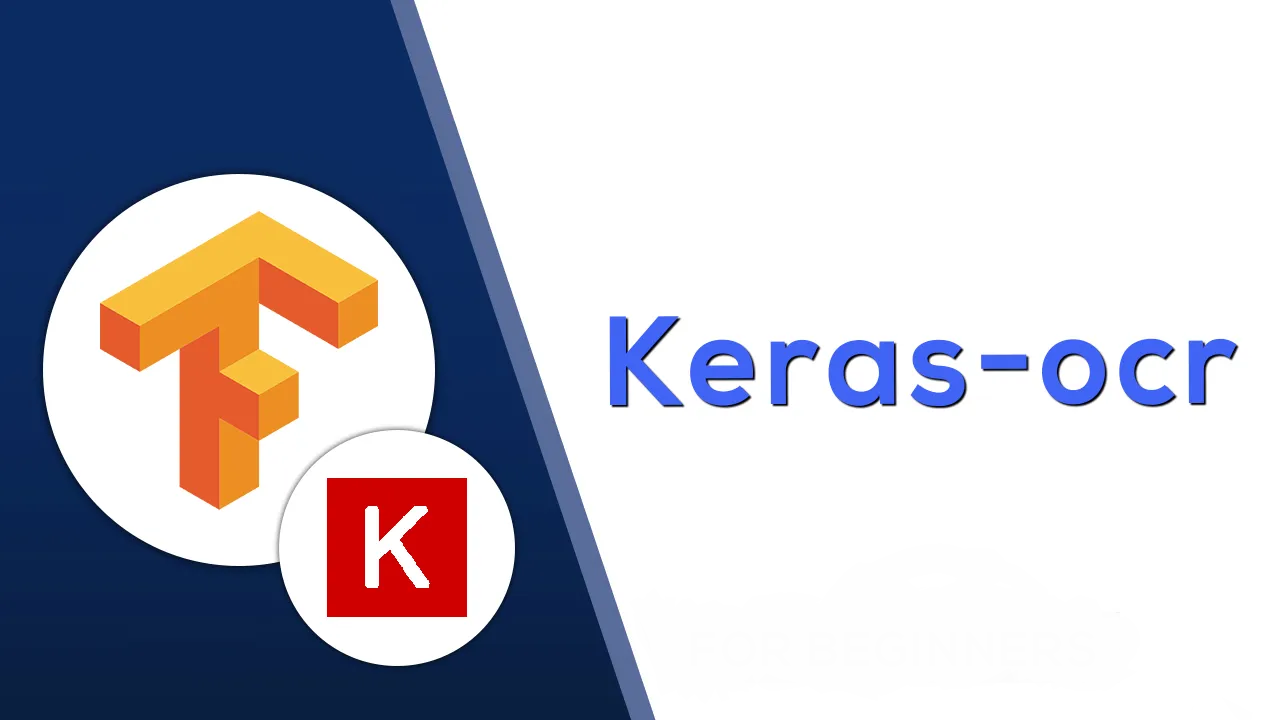

In [2]:
import tensorflow as tf

if tf.test.is_gpu_available():
    !pip install keras-ocr[tf-gpu]
else:
    !pip install keras_ocr

2023-10-27 12:05:34.622953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 7385 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:16:00.0, compute capability: 8.9
2023-10-27 12:05:34.623119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:1 with 10305 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:34:00.0, compute capability: 8.9


In [52]:
import os
import cv2
import random
import keras_ocr
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [6]:
PATH = "../../Datasets/raw_datasets/5.1 clarius_auto_msu_parmar_segmentations/images"
files = os.listdir(PATH)

In [182]:
def compute_grad(image_gray, mode:str)->np.ndarray:
    """
    Function to compute the gradients magnitude of the image 
    set mode to "double" if you want to apply it two times
    """
    # Compute the gradients using the Sobel operator
    dx = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the magnitude and direction of the gradients
    mag = np.sqrt(dx**2 + dy**2)
    
    if mode == "double":
        # Compute the gradients using the Sobel operator
        dx = cv2.Sobel(mag, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(mag, cv2.CV_64F, 0, 1, ksize=3)

        # Compute the magnitude and direction of the gradients
        magmag = np.sqrt(dx**2 + dy**2)
        return (magmag/magmag.max()*255).astype(np.uint8)
        
    return (mag/mag.max()*255).astype(np.uint8)


def detect_draw(pipeline, image_gray, viz):
    img = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
    #read image from the an image path (a jpg/png file or an image url)
    # Prediction_groups is a list of (word, box) tuples
    b = pipeline.recognize([img])
    #print image with annotation and boxes
    if viz:
        plt.imshow(img)
        plt.show()
        keras_ocr.tools.drawAnnotations(image=img, predictions=b[0])
        plt.show()

    return b

def remove(img, bb, offset):
    for box in bb:
        box = np.array(box[1]).reshape((-1,1,2)).astype(np.int32)
        cv2.drawContours(img, [box], 0, (0,0,0),-1)
    # # Create a mask of the same size as the image
    # mask = np.ones_like(image_gray)*255

    # # Draw a white rectangle on the mask within the bounding box
    # cv2.rectangle(mask, (bb[0]-offset, bb[1]-offset), (bb[2]+offset, bb[3]+offset), (0,0,0), -1)

    # # Apply the mask to the original image
    # masked_image = cv2.bitwise_and(image_gray, mask)
    
    return img

In [183]:
def main(pipeline, image_gray, offset):
    mag = compute_grad(image_gray,"single")
    bb = detect_draw(pipeline, mag, viz=True)
    masked_image = remove(image_gray, bb[0], offset)
    return masked_image

In [184]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/alvin/.keras-ocr/craft_mlt_25k.h5
Looking for /home/alvin/.keras-ocr/crnn_kurapan.h5


n:  85


Input image:  (2160, 3840)
1/1 [==============================] - 1s 957ms/step


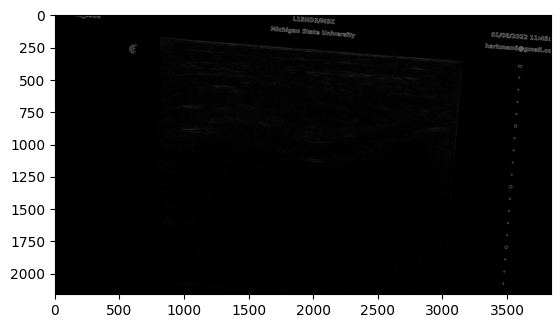

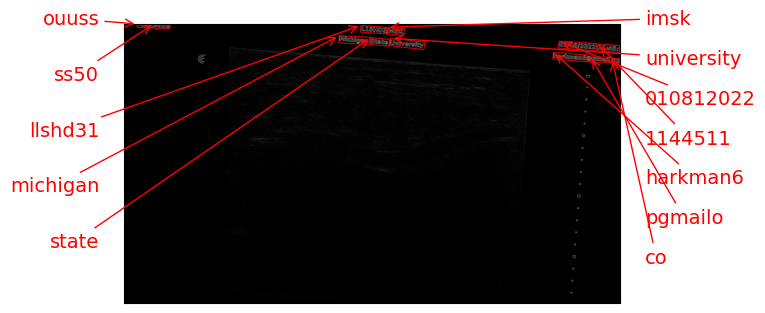

Masked image:  (2160, 3840)


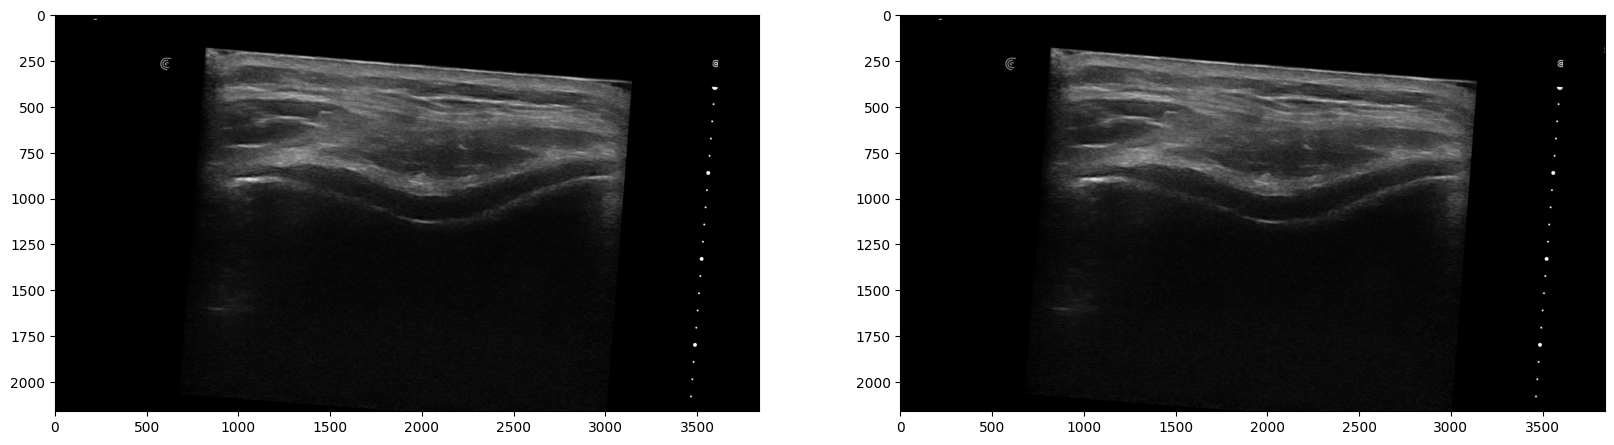

In [185]:
n = random.randint(0,100)
print("n: ", n)
image_gray  = np.array(Image.open(os.path.join(PATH, files[2])))
image_gray  = cv2.imread(os.path.join(PATH, files[n]), cv2.IMREAD_GRAYSCALE)
print("Input image: ", image_gray.shape)
masked_image = main(pipeline,image_gray,40)

print("Masked image: ", masked_image.shape)

fig, ax = plt.subplots(1,2,figsize=(20,7))
ax[0].imshow(image_gray, cmap='gray')
ax[1].imshow(masked_image, cmap='gray')
plt.show()